### Example to mimic old PTW

This is a notebook with parameter values set to mimic the old PTW calibration

In [1]:
using Pkg
pkg"activate ."
pkg"instantiate"
pkg"precompile"

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Precompiling project...


In [2]:
import Pkg; Pkg.add("Plots")
using PerlaTonettiWaugh, Plots, BenchmarkTools

 Resolving package versions...
  Updating `~/Desktop/PerlaTonettiWaugh.jl/Project.toml`
 [no changes]
  Updating `~/Desktop/PerlaTonettiWaugh.jl/Manifest.toml`
 [no changes]


Below is the calibration, the gbm and death rate set to be small values. The otheres are viturally taken from Tabe 1. The only ones that are a bit fuzzy are $\kappa$ which was rounded up and then the $\chi$ which is a bit higher. I beleve that this may have been a typo in the paper.

In [3]:
cal_old_paper = (d = 4.0 , θ = 3.1878, κ = 0.006 , χ = 1.00/2.80, υ = 0.001, σ =3.0, ζ = 1.00, δ = 0.001)
cal = cal_old_paper

(d = 4.0, θ = 3.1878, κ = 0.006, χ = 0.35714285714285715, υ = 0.001, σ = 3.0, ζ = 1.0, δ = 0.001)

In [4]:
# Define common objects. 
parameters = parameter_defaults()

settings = settings_defaults()
settings = merge(settings, (transition_penalty_coefficient = 1.0, ))
z_grid = settings.z
M = length(z_grid)

d_0 = 10.0 # This will get us near autarky.
d_T = cal.d

params_0 = merge(parameters, (d = d_0, θ = cal.θ, κ = cal.κ, χ = cal.χ, υ = cal.υ, σ = cal.σ, ζ = cal.ζ , δ  = cal.δ, )) # parameters to be used at t = 0
params_T = merge(parameters, (d = d_T, θ = cal.θ, κ = cal.κ, χ = cal.χ, υ = cal.υ, σ = cal.σ, ζ = cal.ζ , δ  = cal.δ, )) # parameters to be used at t = T

# initial value
initial_x = [0.02; 2; .57] # Play with this if it is kicking back errors

# solve for stationary solution at t = 0
stationary_sol_atuk = stationary_algebraic(params_0, initial_x) # solution at t = 0
stationary_sol = stationary_algebraic(params_T, initial_x) # solution at t = T

Ω_0 = stationary_sol_atuk.Ω;
Ω_T = stationary_sol.Ω;

In [5]:
display_stationary_sol(stationary_sol);

g = 0.019834399360843635
z_hat = 1.5936783198180449
Ω = 2.884019326629217
y = 2.4782483939708633
c = 2.4782483939708633
U_bar = getfield(PerlaTonettiWaugh, Symbol("##46#47")){Float64,Float64,Float64,Float64}(0.019834399360843635, 0.02, 1.0, 2.4782483939708633)
λ_ii = 0.7556417685825821
L_tilde = 0.22566327836874225
z_bar = 3.200478970892737
w = 1.0668263236309121
x = 1.0
π_min = 0.0377980942709588
r = 0.04083439936084364
a = 16.483480603411472
b = 0.1699991574728411
S = 0.06322301724807734


In [6]:
display_stationary_sol(stationary_sol_atuk);

g = 0.013725354634008428
z_hat = 3.984240500623415
Ω = 3.942882299264948
y = 2.670456862343457
c = 2.670456862343457
U_bar = getfield(PerlaTonettiWaugh, Symbol("##46#47")){Float64,Float64,Float64,Float64}(0.013725354634008428, 0.02, 1.0, 2.670456862343457)
λ_ii = 0.9828742334343247
L_tilde = 0.18613239410555277
z_bar = 3.281193210053621
w = 1.0937310700178737
x = 1.0
π_min = 0.0377972461263284
r = 0.03472535463400843
a = 20.640384751387884
b = 0.7454480347331099
S = 0.04374860446787207


#### Comparison of Steady States

First notice that the growth rate is near similar in autarky to that in Table 2. Then the second part computes the consumption equivalent 

In [7]:
print(stationary_sol_atuk.g,"\n")

print(100*(stationary_sol.U_bar(0)/stationary_sol_atuk.U_bar(0)-1),"\n")

lambda_ss = 100*(consumption_equivalent(stationary_sol.U_bar(0), stationary_sol_atuk.U_bar(0), parameters)-1)

print("SS to SS welfare gain: ", lambda_ss,"\n")

0.013725354634008428
13.829924754095924
SS to SS welfare gain: 25.955021744955985


So all this stuff is roughly matching up with what we had in Table 2. About a 1.38 growth rate, 13 percent increase in utility, 26 (24 in paper) in consumption units.

#### Transition Path

In [8]:
settings = merge(settings, (params_T = params_T, stationary_sol_T = stationary_numerical(params_T, z_grid), Ω_0 = Ω_0, transition_iterations = 1000, T = 75.0));

#### Continuation Approach

In [17]:
result.E_nodes

14-element Array{Float64,1}:
  0.009753078928381436  
 -0.00010592610456495418
  0.0005762512024997002 
  0.0021534737298133672 
  8.446402769356554e-5  
  0.0013575723625121772 
 -0.0008627826615122766 
  0.0033504368853715526 
 -0.0007023107000801089 
  0.001979138186301147  
  3.637157634517308e-5  
 -0.0013717456718342885 
  9.84739242364864e-6   
  2.898938073653283e-5  

In [9]:
@time settings, result = solve_continuation(d_0, d_T, step = 0.25)

┌ Warning: `binary_maxheap(xs::AbstractVector{T}) where T` is deprecated, use `BinaryMaxHeap(xs)` instead.
│   caller = #FunctionCallingCallback#24(::Array{Float64,1}, ::Bool, ::Bool, ::Int64, ::Function, ::Function) at function_caller.jl:75
└ @ DiffEqCallbacks /home/arnavsood/.julia/packages/DiffEqCallbacks/WQXZl/src/function_caller.jl:75
┌ Warning: `binary_maxheap(xs::AbstractVector{T}) where T` is deprecated, use `BinaryMaxHeap(xs)` instead.
│   caller = tstop_saveat_disc_handling at solve.jl:514 [inlined]
└ @ Core /home/arnavsood/.julia/packages/Sundials/AL2Km/src/common_interface/solve.jl:514
┌ Warning: `binary_maxheap(xs::AbstractVector{T}) where T` is deprecated, use `BinaryMaxHeap(xs)` instead.
│   caller = #__init#58(::Bool, ::Nothing, ::Float64, ::Bool, ::Bool, ::DiffEqBase.DiscreteCallback{getfield(DiffEqCallbacks, Symbol("##25#26")),DiffEqCallbacks.FunctionCallingAffect{getfield(PerlaTonettiWaugh, Symbol("#cb_aux#81")){getfield(PerlaTonettiWaugh, Symbol("#Ω#125")){Float64,O

3051.679695 seconds (7.48 G allocations: 7.849 TiB, 25.20% gc time)


((z_max = 5, z = [0.0, 0.000250627, 0.000501253, 0.00075188, 0.00100251, 0.00125313, 0.00150376, 0.00175439, 0.00200501, 0.00225564  …  4.63636, 4.67677, 4.71717, 4.75758, 4.79798, 4.83838, 4.87879, 4.91919, 4.9596, 5.0], Δ_E = 1.0e-6, ode_solve_algorithm = Sundials.CVODE_BDF{:Newton,:Dense}(0, 0, 0, 0, false, 10, 5, 7, 3, 10), T = 40.0, t = 0.0:4.444444444444445:40.0, g = [0.0306157, 0.0406157, 0.0506157, 0.0606157, 0.0706157, 0.0806157, 0.0906157, 0.100616, 0.110616, 0.120616], E_node_count = 15, entry_residuals_nodes_count = 15, transition_x0 = [0.00975308, -0.000105926, 0.000576251, 0.00215347, 8.4464e-5, 0.00135757, -0.000862783, 0.00335044, -0.000702311, 0.00197914, 3.63716e-5, -0.00137175, 9.84739e-6, 2.89894e-5], fifty_node_iv = [-1.00157, -0.848157, -0.821211, -0.821211, -0.821211, -0.748497, -0.633587, -0.527711, -0.498239, -0.498239  …  -0.0713765, -0.0343871, -0.0334064, -0.0334064, -0.029373, -0.029373, -0.029373, -0.029373, -0.029373, -0.029373], continuation_x0 = [0.0, 0

#### Standard Approach

In [14]:
solved = result.solution;
E_nodes = result.E_nodes;

solved = solved.results;

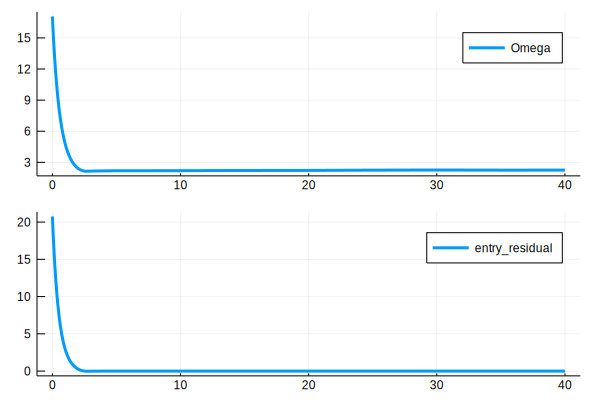

In [15]:
plot_Ω = plot(solved.t, solved.Ω, label = "Omega", lw = 3)
plot_residual = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot_Ω, plot_residual, layout = (2,1))

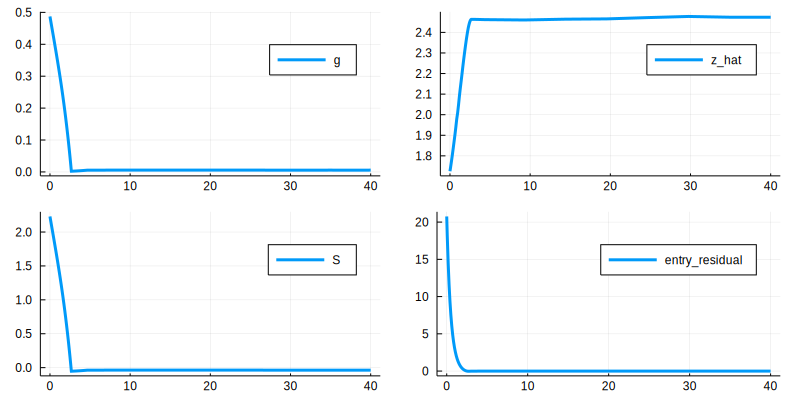

In [16]:
plot1 = plot(solved.t, solved.g, label = "g", lw = 3)
plot2 = plot(solved.t, solved.z_hat, label = "z_hat", lw = 3)
plot3 = plot(solved.t, solved.S, label = "S", lw = 3)
plot4 = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot1, plot2, plot3, plot4, layout=(2,2), size = (800, 400))

#### Welfare Including Transition Path

Here it is

In [13]:
lambda_tpath = 100*(consumption_equivalent(solved.U[1], stationary_sol_atuk.U_bar(0), parameters)-1)

print("Inclusive of the Transition Path: ", lambda_tpath,"\n")

UndefVarError: UndefVarError: solved not defined

So the transition makes welfare INCREASE by a factor of 4....